### Fig. 5E, F

In [3]:
# Import Libraries
from caveclient import CAVEclient
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
# from my_functions import *
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.patches as mpatches
import gspread
from collections import Counter
import math
import sys
from itertools import compress

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

client = CAVEclient()

datastack_name = 'fanc_production_mar2021'

client = CAVEclient(datastack_name)

# fig_path = 'C:/Users/swetarr/Documents/GitHub/feco-connectomics-analysis/figures/'
# csv_path = 'C:/Users/swetarr/Documents/GitHub/feco-connectomics-analysis/csv/'

pd.set_option('display.max_rows', 400)

sys.path.append("C:/Users/swetarr/Documents/GitHub/fancy_tools/synapse_analysis/")
    
from connectivity_matrix import *

import time
timestr = time.strftime("%Y%m%d")

In [4]:
# code to access Tony's MN labels, currently not working
MN_df = client.materialize.query_table('motor_neuron_table_v7',timestamp='now')
MN_df['pt_position'] = MN_df['pt_position'].apply(lambda x: tuple(x))

ordered_t1_table = client.materialize.live_live_query('left_t1_mn_order_module_table_v1',timestamp='now')
ordered_t1_table['pt_position'] = ordered_t1_table['pt_position'].apply(lambda x: tuple(x))
ordered_t1_table['tag'] = ordered_t1_table['tag'].apply(lambda x: int(x))

MN_df = MN_df.merge(ordered_t1_table,how='right',left_on='pt_position',right_on='pt_position')
MN_df = MN_df[['classification_system','cell_type','pt_position','tag','tag2','pt_root_id_x']]
MN_df = MN_df.rename(columns={'pt_root_id_x':'pt_root_id'})

MN_ids = MN_df.pt_root_id.to_list()

MN_modules = list(set(MN_df.tag2.to_list()))

In [5]:
# Specify the root_ids of the sensory neurons that we care about, put them into a list
FeCO_df= client.materialize.query_table('feco_axons_v0')
FeCO_df = FeCO_df[FeCO_df['classification_system'].str.contains('T1L')]
FeCO_df = FeCO_df.replace(to_replace='maybeclub', value='club')
FeCO_df = FeCO_df.replace(to_replace='club_asc', value='club')

hook_ids = FeCO_df[FeCO_df['cell_type'].str.contains('hook')]['pt_root_id'].to_list()
hook_types = FeCO_df[FeCO_df['cell_type'].str.contains('hook')]['cell_type'].to_list()

claw_ids = FeCO_df[FeCO_df['cell_type'].str.contains('claw')]['pt_root_id'].to_list()
claw_types = FeCO_df[FeCO_df['cell_type'].str.contains('claw')]['cell_type'].to_list()

club_ids = FeCO_df[FeCO_df['cell_type'].str.contains('club')]['pt_root_id'].to_list()
club_types = FeCO_df[FeCO_df['cell_type'].str.contains('club')]['cell_type'].to_list()

allFeCO_ids = claw_ids+hook_ids+club_ids
allFeCO_types = claw_types+hook_types+club_types
FeCO_dict = dict(zip(allFeCO_ids,allFeCO_types))

FeCO_modules = list(set(allFeCO_types))

C:\Users\swetarr\anaconda3\envs\connectomics\lib\site-packages\pandas\core\missing.py:95: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  new_mask = arr == x


In [6]:
#find all the postsynaptic partners that receive more than 3 synapses from an FeCO neuron.

syn_threshold = 3; 

outputs = client.materialize.synapse_query(pre_ids = allFeCO_ids)
syn_per_output = outputs.groupby(['pre_pt_root_id','post_pt_root_id'])['post_pt_root_id'].count().reset_index(name="number_of_synapses").sort_values(by=['number_of_synapses'], ascending=False).reset_index(drop=True)
syn_per_output = syn_per_output[[ "pre_pt_root_id", "post_pt_root_id", "number_of_synapses"]][syn_per_output['number_of_synapses'] > syn_threshold]

DS_ids = syn_per_output.drop_duplicates(subset = "post_pt_root_id")['post_pt_root_id'].to_list()
DS_df = pd.DataFrame({'pt_root_id': DS_ids})

## use downstream tables to pull out information about types of neurons. mainly using this for the NT for now.

### calculate FeCO "module" preference score

In [7]:
module_scores = []
top_module = []
all_totalsyns = []
for i, ds_id in enumerate(DS_ids):
    for j, sensory_module in enumerate(FeCO_modules):
        theseFeCOids = FeCO_df.query('cell_type==@sensory_module')['pt_root_id'].to_list()
        if j==0:
            module_syns = syn_per_output.query('pre_pt_root_id in @theseFeCOids and post_pt_root_id==@ds_id')['number_of_synapses'].sum()
        else:
            module_syns = np.append(module_syns, syn_per_output.query('pre_pt_root_id in @theseFeCOids and post_pt_root_id==@ds_id')['number_of_synapses'].sum())
                
    totalsyns = np.sum(module_syns)
    all_totalsyns.append(totalsyns)
    if totalsyns == 0:
        module_scores.append(np.zeros(len(FeCO_modules)))
        top_module.append(np.nan)
    else:
        module_scores.append(module_syns/totalsyns)
        top_module.append((FeCO_modules[np.argmax(module_syns/totalsyns)]))
        
DS_df['sensory_module_scores'] = module_scores
DS_df['top_sensory_module_score'] = DS_df.sensory_module_scores.apply(max)
DS_df['top_sensory_module'] = top_module
DS_df['total_sensory_syns'] = all_totalsyns


#get rid of those DS rows that don't seem to be connected to any sensory neurons
DS_df = DS_df.drop(DS_df[DS_df['top_sensory_module_score'] == 0.000000].index)
DS_ids = DS_df['pt_root_id'].to_list()


### calculate MN "module" preference score

In [8]:
syn_threshold = 3; 

DS_MN = client.materialize.synapse_query(pre_ids = DS_ids, post_ids = MN_ids)
syn_per_DSMN = DS_MN.groupby(['pre_pt_root_id','post_pt_root_id'])['post_pt_root_id'].count().reset_index(name="number_of_synapses").sort_values(by=['number_of_synapses'], ascending=False).reset_index(drop=True)
syn_per_DSMN = syn_per_DSMN[[ "pre_pt_root_id", "post_pt_root_id", "number_of_synapses"]][syn_per_DSMN['number_of_synapses'] > syn_threshold]

module_scores = []
top_module = []
all_totalsyns = []

for i, ds_id in enumerate(DS_ids):
    for j, motor_module in enumerate(MN_modules):
        theseMNids = MN_df.query('tag2==@motor_module')['pt_root_id'].to_list()
        if j==0:
            module_syns = syn_per_DSMN.query('post_pt_root_id in @theseMNids and pre_pt_root_id==@ds_id')['number_of_synapses'].sum()
        else:
            module_syns = np.append(module_syns, syn_per_DSMN.query('post_pt_root_id in @theseMNids and pre_pt_root_id==@ds_id')['number_of_synapses'].sum())
                
    totalsyns = np.sum(module_syns)
    all_totalsyns.append(totalsyns)
    if totalsyns == 0:
        module_scores.append(np.zeros(len(MN_modules)))
        top_module.append(np.nan)
    else:
        module_scores.append(module_syns/totalsyns)
        top_module.append((MN_modules[np.argmax(module_syns/totalsyns)]))
        
DS_df['motor_module_scores'] = module_scores
DS_df['top_motor_module_score'] = DS_df.motor_module_scores.apply(max)
DS_df['top_motor_module'] = top_module
DS_df['total_motor_syns'] = all_totalsyns

### plots of sensory and motor module preference scores

In [9]:
melted_DSdf = pd.melt(DS_df, id_vars = ['pt_root_id', 'top_sensory_module', 'top_motor_module'], value_vars=['top_sensory_module_score', 'top_motor_module_score'])
# melted_DSdf

filtered_df = DS_df[(DS_df[['top_motor_module_score','top_sensory_module_score']] != 0).all(axis=1)]

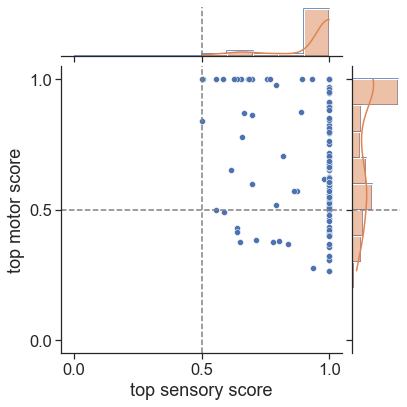

In [10]:
#scatterplot of sensory module versus motor module preference, with joint distributions
sns.set_context("poster")
figure_size = [40, 40]
sns.set(font_scale=1.5)
sns.set_style("ticks")

g = sns.jointplot(data=filtered_df, x="top_sensory_module_score", y="top_motor_module_score", 
                  marginal_kws=dict(bins=10, fill=False, binrange=[0,1]))

# g = sns.jointplot(data=DS_df, x="top_sensory_module_score", y="top_motor_module_score", 
#                   marginal_kws=dict(bins=10, fill=False, binrange=[0,1]))



g.plot_marginals(sns.histplot, kde=True, bins=10, binrange=[0,1])

g.ax_joint.set(ylim=(-0.05, 1.05), xlim=(-0.05, 1.05), yticks=[0, 0.5, 1], xticks=[0, 0.5, 1], 
               ylabel="top motor score", xlabel="top sensory score")
# g.ax_joint.legend(bbox_to_anchor=(1.5, 1), loc='upper left', borderaxespad=0)

g.refline(x=0.5, y=0.5)

# g.savefig(fig_path+'module_joint.pdf', dpi = 300, bbox_inches = 'tight')

In [11]:
# DS_df = pd.concat([intersegmental_df, local_df], ignore_index=True)

#get rid of those DS rows that don't seem to be connected to any MNs
DS_df = DS_df.drop(DS_df[DS_df['top_motor_module_score'] == 0.000000].index)

#sort the DF
DS_df.sort_values(by = ['top_motor_module', 'top_sensory_module'], ascending=[True, False], inplace=True, ignore_index=True)
# filtered_DS = DS_df[DS_df['cell_type'].str.contains('22A')]

# motor_scores = DS_df['motor_module_scores'].apply(pd.Series)
motor_scores = DS_df['motor_module_scores'].apply(pd.Series)
motor_scores.set_axis(MN_modules, axis=1,inplace=True)

# sensory_scores = DS_df['sensory_module_scores'].apply(pd.Series)
sensory_scores = DS_df['sensory_module_scores'].apply(pd.Series)
sensory_scores.set_axis(FeCO_modules, axis=1,inplace=True)

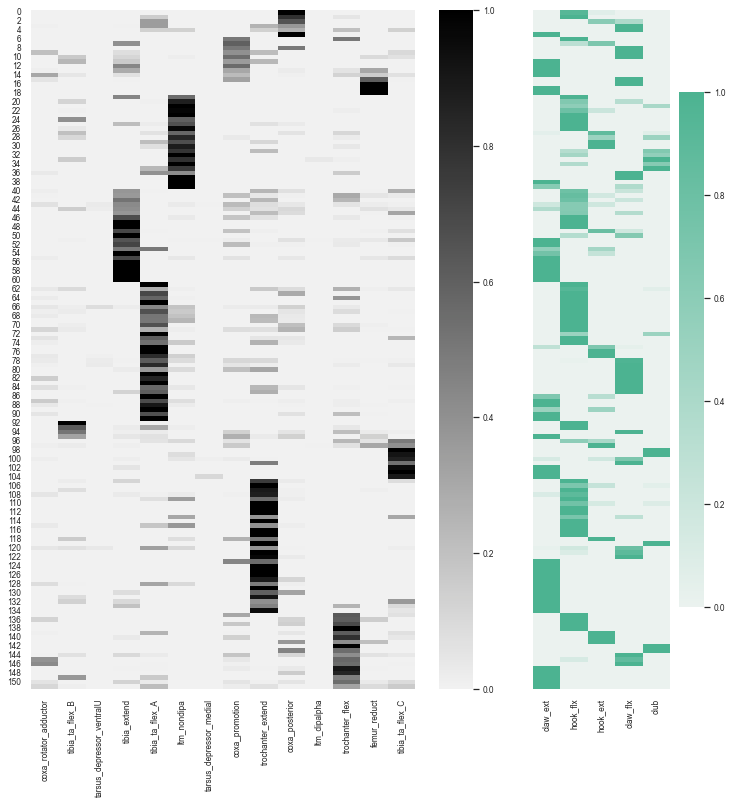

In [15]:
# create multiple heatmaps each of different neurotransmitters or different sign


#excitatory/ach
# filtered_DS = DS_df[DS_df['sign'].str.contains('I')]
filtered_DS = DS_df

motor_scores = filtered_DS['motor_module_scores'].apply(pd.Series)
motor_scores.set_axis(MN_modules, axis=1,inplace=True)

sensory_scores = filtered_DS['sensory_module_scores'].apply(pd.Series)
sensory_scores.set_axis(FeCO_modules, axis=1,inplace=True)



sns.set_context("poster")
sns.set(font_scale = 0.75)
widths = [len(motor_scores.columns), len(sensory_scores.columns)]
motor_cmap = sns.light_palette("#000000", as_cmap=True)
sensory_cmap = sns.light_palette("#4CB391", as_cmap=True)

f ,axs =plt.subplots(1,2,figsize=(10,10), sharey=True, sharex=False, gridspec_kw={'width_ratios': widths})
f.tight_layout()


sns.heatmap(motor_scores, cmap=motor_cmap, vmin=0, vmax=1, ax=axs[0], xticklabels = 1)#, yticklabels=HLs)
sns.heatmap(sensory_scores, cmap=sensory_cmap, vmin=0, vmax=1, ax=axs[1], xticklabels = 1)#, yticklabels=HLs)

fig_path = 'C:/Users/swetarr/Documents/GitHub/feco-connectomics-analysis/figures/'
f.savefig(fig_path+'preMNconnectivity_modulescores.pdf', dpi = 300, bbox_inches = 'tight')